In [60]:
import csv
import numpy as np
import utils
import hrr_utils
import time
import random

from fastdtw import fastdtw
from scipy import spatial
from scipy.spatial import distance
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

N=100

def genX(verbs, indices):
    X = np.zeros((len(verbs), N)) # Exclusively difference PAST1-PRES1
    PRES1 = np.zeros((len(verbs), N))
    PRES2 = np.zeros((len(verbs), N))
    PAST1 = np.zeros((len(verbs), N))
    PAST2 = np.zeros((len(verbs), N))
    
    for m in range(len(indices)):
        pair = verbs[indices[m]]
        past1 = hrr_utils.GetRVClipHash(pair[1], dic1, 3)
        past2 = hrr_utils.GetRVClipHash(pair[1], dic2, 3)
        pres1 = hrr_utils.GetRVClipHash(pair[0], dic1, 3)
        pres2 = hrr_utils.GetRVClipHash(pair[0], dic2, 3)
        PRES1[m] = pres1
        PRES2[m] = pres2
        PAST1[m] = past1
        PAST2[m] = past2

    #X = np.where(PAST1-PRES1 > 0, 1, -1)
    X = PAST1-PRES1
    return X, PRES1, PRES2, PAST1, PAST2

def train(tv, past, present):
    tv += np.multiply(past, present)
    return tv

def reg_train(tv, past, present, sim):
    pred = np.multiply(tv, present)
    #pred = np.where(pred>0, 1, -1)
    #print (sim(pred, past)),
    tv += ((N-sim(pred, past))/float(N)) * np.multiply(past, present)
    return tv

def train_diff(tv, past2, present1, present2):
    tv += np.multiply(present1, past2-present2)
    return tv

def reg_train_diff(tv, past2, present1, present2, sim):
    pred = np.multiply(tv, present1) + present2
    #pred = np.where(pred>0, 1, -1)
    #print (sim(pred, past)),
    tv += ((N-sim(pred, past2))/float(N)) * np.multiply(past2-present2, present1)
    return tv

def outer_train(W, past, present):
    # col x row
    W += np.outer(present, past)
    return W

def outer_reg_train(W, Past, Present, sim):
    pred = np.dot(W, Present)
    W += ((N*N-sim(pred, Past))/float(N*N)) * np.outer(Past, Present)
    return W

def outer_train_diff(W, past2, present1, present2):
    W += np.outer(present1, past2-present2)
    return W

def outer_reg_train_diff(W, past2, present1, present2, sim):
    #W.T.dot(trainpres1[:k].T).T + trainpres2[:k]*N
    pred = np.dot(W, present1) + present2*N
    W += ((N*N-sim(pred, past2))/float(N*N)) * np.outer(present1, past2-present2)
    return W

def closed_train(Past, Present):
    return np.dot(np.linalg.pinv(Present), Past)

def cap_closed_train(Past, Present):
    return np.dot(np.linalg.pinv(Present,rcond=5e-2), Past)

def cos_sim(x, y, dist=None):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

# pretty useless
def pseudo_corr(x, y, dist=None):
    if len(x.shape) == 1 or len(y.shape)==1:
        return 1/float(np.dot(x, y))
    return 1/np.sum(np.multiply(x, y), axis=1).astype(float)

def corr(x, y, dist=None):
    if x.shape[0] == 1 or y.shape[0] ==1:
        rv = np.correlate(x.T.reshape(x.shape[1]), 
                            y.T.reshape(y.shape[1]),
                            mode='valid')
        return rv
    return np.asarray([np.correlate(x[i], y[i], mode='valid') for i in range(x.shape[0])])

# https://pypi.python.org/pypi/fastdtw
def dtw_sim(x, y, dist):
    if len(x.shape) == 1 or len(y.shape)==1:
        distance, path = fastdtw(x, y, dist=dist)
        return distance
    distances = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        distances[i], _ = fastdtw(x[i], y[i], dist=dist)
    return distances

def round_to_tick(number):
    """Round a number to the closest half integer."""
    return round(number * 2) / 2

def graph(x, y1, y2, y1std, y2std, title=None, xlabel='number of words', ylabel='average dot product', legend='upper left'):   
    fig = plt.figure(figsize=(4,3))
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
#     plt.xticks(np.arange(0, 1701, 400))
    
    start = round_to_tick(min(min(y1), min(y2)) - max(max(y1std),max(y2std)))
    end = round_to_tick(max(max(y1), max(y2)) + max(max(y1std),max(y2std)))
    
    y1std = np.clip(y1std, max(-8, start-.5), min(8, end+.5))
    y2std = np.clip(y2std, max(-8, start-.5), min(8, end+.5))
    
    plt.yticks(np.arange(max(-8, start-.5), min(8, end+.5), .5))
#     plt.plot([0, 1700], [0, 0], 'k')

    plt.plot(x, y1, c='b', lw=2, label='Train')
    plt.plot(x, y2, c='g', lw=2, label='Test')

    plt.fill_between(x, y1-y1std, y1+y1std, facecolor='b', alpha=0.1)
    plt.fill_between(x, y2-y2std, y2+y2std, facecolor='g', alpha=0.1)
    
#     plt.fill_between(x, y2-y2std, y2+y2std, color='none', alpha=0.3, hatch="////", edgecolor="g")


#     plt.legend(loc=legend,fontsize=12)

    plt.xlabel('Number Training Examples',fontsize=16)
    plt.ylabel('Feature Similarity',fontsize=16)
#     plt.title(title,fontsize=16)

#     plt.xlim([0, 1700])

    plt.tight_layout()



In [69]:
reg_pres, reg_past, reg_freq = utils.GetRegularVerbs(frequency=1)
irreg_pres, irreg_past, irreg_freq = utils.GetIrregularVerbs(frequency=1)


regular = zip(reg_pres, reg_past, reg_freq)
irregular = zip(irreg_pres, irreg_past, irreg_freq)

regular = regular[:500]
irregular = irregular[:500]
train_frac = 2/3.0

irregular_train_idx = int(train_frac*len(irreg_pres))
train_irreg = irregular[0:irregular_train_idx]

regular_train_idx = 500 - len(train_irreg) 
train_reg = regular[0:regular_train_idx]

test_reg = regular[regular_train_idx:]
test_irreg = irregular[irregular_train_idx:]

dic1 = hrr_utils.GenerateDefaultDictionary(N)
dic2 = hrr_utils.GenerateDefaultDictionary(N)

train_all = train_reg + train_irreg
test_all = test_reg + test_irreg

train_all_indices = [i for i in range(len(train_all))]
test_all_indices = [i for i in range(len(test_all))]
random.shuffle(train_all_indices)
random.shuffle(test_all_indices)

In [70]:
trainX, trainpres1, trainpres2, trainpast1, trainpast2 = genX(train_all,train_all_indices)
testX, testpres1, testpres2, testpast1, testpast2 = genX(test_all, test_all_indices)

In [5]:
def trigam_dict(train_func, sim, dist=None):
    psi = np.zeros(N)
    psi = train(psi, trainpast2[0], trainpres1[0])
    random_vecs = np.random.randn(testpast2.shape[0], N)
    x = np.arange(1, trainpres1.shape[0]+1, 1)
    y1 = np.zeros(trainpres1.shape[0])
    y2 = np.zeros(trainpres1.shape[0])
    y1std = np.zeros(trainpres1.shape[0])
    y2std = np.zeros(trainpres1.shape[0])

    y1irregular = np.zeros(trainpres1.shape[0])
    y2irregular = np.zeros(trainpres1.shape[0])

    sim2indices = [i for i in range(testpres1.shape[0]) if test_all_indices[i] >= len(test_reg)]


    for k in range(1,len(trainpres1)):#trainpres1.shape[0]):
        train_pred = np.multiply(psi, trainpres1[:k])
        #train_pred = np.where(train_pred>0, 1, -1)
        test_pred = np.multiply(psi, testpres1)
        #test_pred = np.where(test_pred>0, 1, -1)

        sim1 = sim(train_pred, trainpast2[:k], dist)
        sim2 = sim(test_pred, testpast2, dist)
        
        sim1indices = [i for i in range(sim1.shape[0]) if train_all_indices[i] >= len(train_reg)]

        irregularsim1 = sim1[sim1indices]
        irregularsim2 = sim2[sim2indices]

        y1[k] = sim1.mean()/N
        y1std[k] = np.nanstd(sim1, axis=0)/N #/ (arange(len(train_mean))+1) ** 0.5
        y2[k] = sim2.mean()/N
        y2std[k] = sim2.std(axis=0)/N #/ testpast2.shape[0]**0.5
#         print (y1[k], y2[k])
        y1irregular[k] = irregularsim1.mean()/N
        y2irregular[k] = irregularsim2.mean()/N

        psi = train_func(psi, trainpast2[k], trainpres1[k])
    return x,y1,y2,y1std,y2std

In [9]:
x,y1,y2,y1std,y2std = trigam_dict(train, cos_sim)

/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: Mean of empty slice.


figures/unregularized_trigam_dict-N=10-W=10-170831


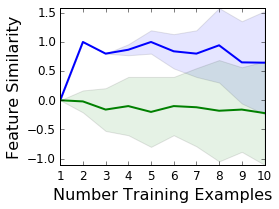

In [10]:
title = 'unregularized'
legend = 'upper left'
graph(x,y1,y2,y1std,y2std,title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [13]:
pseudocorr_x,pseudocorr_y1,pseudocorr_y2,pseudocorr_y1std,pseudocorr_y2std = trigam_dict(train, pseudo_corr)

/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:96: RuntimeWarning: divide by zero encountered in divide
/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: Mean of empty slice.


figures/unregularized_trigam_dict-N=10-W=10-170831


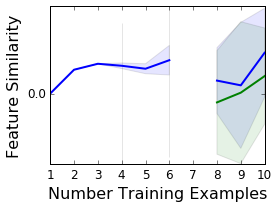

In [14]:
title = 'unregularized'
legend = 'upper left'
graph(pseudocorr_x,pseudocorr_y1,pseudocorr_y2,pseudocorr_y1std,pseudocorr_y2std,title=title,legend=legend)

fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [16]:
corr_x,corr_y1,corr_y2,corr_y1std,corr_y2std = trigam_dict(train, corr)

/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: Mean of empty slice.


figures/unregularized_trigam_dict-N=10-W=10-170831


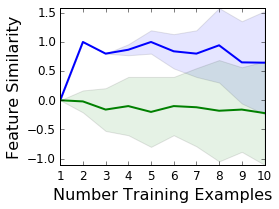

In [18]:
title = 'unregularized'
legend = 'upper left'
graph(corr_x,corr_y1,corr_y2,corr_y1std,corr_y2std,title=title,legend=legend)

fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [17]:
dtw_cos_x,dtw_cos_y1,dtw_cos_y2,dtw_cos_y1std,dtw_cos_y2std = trigam_dict(train, dtw_sim, distance.cosine)

/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: Mean of empty slice.


figures/unregularized_trigam_dict-N=10-W=10-170831


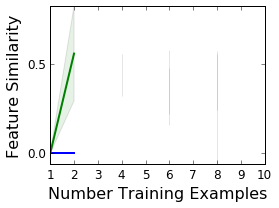

In [18]:
title = 'unregularized'
legend = 'upper left'
graph(dtw_cos_x,dtw_cos_y1,dtw_cos_y2,dtw_cos_y1std,dtw_cos_y2std,title="unregularized",legend="upper left")

fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [19]:
dtw_corr_x,dtw_corr_y1,dtw_corr_y2,dtw_corr_y1std,dtw_corr_y2std = trigam_dict(train, dtw_sim, distance.correlation)

/Users/quinntran/anaconda/lib/python2.7/site-packages/scipy/spatial/distance.py:543: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(um, vm) / (norm(um) * norm(vm))
/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: Mean of empty slice.


figures/unregularized_trigam_dict-N=10-W=10-170831


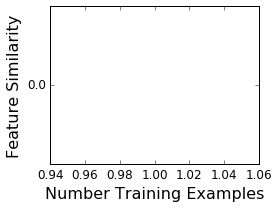

In [21]:
title = 'unregularized'
legend = 'upper left'
graph(dtw_corr_x,dtw_corr_y1,dtw_corr_y2,dtw_corr_y1std,dtw_corr_y2std,title=title,legend=legend)

fname =  ('figures/' + title + '_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [24]:
def diff_trigam_dict(train_func, sim, dist=None):
    diffpsi = np.zeros(N)
    diffpsi = train_diff(diffpsi, trainpast2[0], trainpres1[0], trainpres2[0])

    diffx = np.arange(1, trainpres1.shape[0]+1, 1)
    diffy1 = np.zeros(trainpres1.shape[0])
    diffy2 = np.zeros(trainpres1.shape[0])
    diffy1std = np.zeros(trainpres1.shape[0])
    diffy2std = np.zeros(trainpres1.shape[0])

    diffy1irregular = np.zeros(trainpres1.shape[0])
    diffy2irregular = np.zeros(trainpres1.shape[0])

    sim2indices = [i for i in range(testpres1.shape[0]) if test_all_indices[i] >= len(test_reg)]

    for k in range(1,len(trainpres1)):#trainpres1.shape[0]):
        train_pred = np.multiply(diffpsi, trainpres1[:k]) + trainpres2[:k]
        #train_pred = np.where(train_pred>0, 1, -1)
        test_pred = np.multiply(diffpsi, testpres1) + testpres2
        #test_pred = np.where(test_pred>0, 1, -1)

        sim1 = sim(train_pred, trainpast2[:k])
        sim2 = sim(test_pred, testpast2)

        sim1indices = [i for i in range(sim1.shape[0]) if train_all_indices[i] >= len(train_reg)]

        irregularsim1 = sim1[sim1indices]
        irregularsim2 = sim2[sim2indices]

        diffy1[k] = sim1.mean()/N
        diffy1std[k] = np.nanstd(sim1, axis=0)/N #/ (arange(len(train_mean))+1) ** 0.5
        diffy2[k] = sim2.mean()/N
        diffy2std[k] = sim2.std(axis=0)/N #/ testpast2.shape[0]**0.5

        diffy1irregular[k] = irregularsim1.mean()/N
        diffy2irregular[k] = irregularsim2.mean()/N

        diffpsi = train_func(diffpsi, trainpast2[k], trainpres1[k], trainpres2[k])
    return diffx,diffy1,diffy2,diffy1std,diffy2std

In [25]:
diffx,diffy1,diffy2,diffy1std,diffy2std = diff_trigam_dict(train_diff, cos_sim)

/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: RuntimeWarning: Mean of empty slice.


figures/diff-unregularized_trigam_dict-N=10-W=10-170831


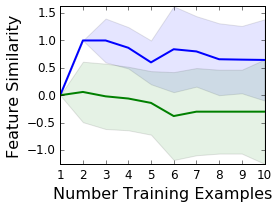

In [26]:
title = 'diff-unregularized'
legend = 'upper left'

graph(diffx,diffy1,diffy2,diffy1std,diffy2std,title=title,legend=legend)

fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [35]:
outerW = np.zeros((N,N))
outerW = outer_train(outerW, trainpast2[0], trainpres1[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
outerx = np.arange(1, trainpres1.shape[0], 1)
outery1 = np.zeros(outerx.shape[0])
outery2 = np.zeros(outerx.shape[0])

outery1std = np.zeros(outerx.shape[0])
outery2std = np.zeros(outerx.shape[0])

outery1irregular = np.zeros(outerx.shape[0])
outery2irregular = np.zeros(outerx.shape[0])

sim2indices = [j for j in range(testpres1.shape[0]) if test_all_indices[j] >= len(test_reg)]

for i in range(outerx.shape[0]):
    k = outerx[i]
    train_pred = outerW.T.dot(trainpres1[:k].T).T
    test_pred = outerW.T.dot(testpres1.T).T

    sim1 = cos_sim(train_pred, trainpast2[:k])
    sim2 = cos_sim(test_pred, testpast2)
    
    sim1indices = [j for j in range(sim1.shape[0]) if train_all_indices[j] >= len(train_reg)]

    irregularsim1 = sim1[sim1indices]
    irregularsim2 = sim2[sim2indices]
    
    outery1[i] = sim1.mean()/N**2
    outery1std[i] = np.nanstd(sim1, axis=0)/N**2
    outery2[i] = sim2.mean()/N**2
    outery2std[i] = np.nanstd(sim2, axis=0)/N**2
    
    outery1irregular[i] = irregularsim1.mean()/N**2
    outery2irregular[i] = irregularsim2.mean()/N**2
    
    
    outerW = outer_train(outerW, trainpast2[k], trainpres1[k])


/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: Mean of empty slice.


figures/regression-unregularized_outer_trigam_dict-N=10-W=10-170831


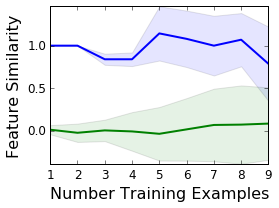

In [36]:
graph(outerx,outery1,outery2,outery1std,outery2std,title="unregularized", legend="upper left")

fname =  ('figures/regression-unregularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname
plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [37]:
outerdiffW = np.zeros((N,N))
outerdiffW = outer_train_diff(outerdiffW, trainpast2[0], trainpres1[0], trainpres2[0])

outerdiffx = np.arange(1, trainpres1.shape[0], 1)
outerdiffy1 = np.zeros(outerdiffx.shape[0])
outerdiffy2 = np.zeros(outerdiffx.shape[0])

outerdiffy1std = np.zeros(outerdiffx.shape[0])
outerdiffy2std = np.zeros(outerdiffx.shape[0])

outerdiffy1irregular = np.zeros(outerdiffx.shape[0])
outerdiffy2irregular = np.zeros(outerdiffx.shape[0])

sim2indices = [j for j in range(testpres1.shape[0]) if test_all_indices[j] >= len(test_reg)]

for i in range(outerdiffx.shape[0]):#trainpres1.shape[0]):
    k = outerdiffx[i]
    train_pred = trainpres1[:k].dot(outerdiffW)
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = testpres1.dot(outerdiffW)
    #test_pred = np.where(test_pred>0, 1, -1)
    
    train_pred = outerdiffW.T.dot(trainpres1[:k].T).T + trainpres2[:k]*N
    test_pred = outerdiffW.T.dot(testpres1.T).T + (testpres2*N)
    
    #y1[i] = sim(train_pred/float(N), trainpast2[:k]).mean()
    #y2[i] = sim(test_pred/float(N), testpast2).mean()
    
    sim1 = cos_sim(train_pred, trainpast2[:k])
    sim2 = cos_sim(test_pred, testpast2)
    
    sim1indices = [j for j in range(sim1.shape[0]) if train_all_indices[j] >= len(train_reg)]

    irregularsim1 = sim1[sim1indices]
    irregularsim2 = sim2[sim2indices]
    
    outerdiffy1[i] = sim1.mean()/N**2
    outerdiffy1std[i] = np.nanstd(sim1, axis=0)/N**2
    outerdiffy2[i] = sim2.mean()/N**2
    outerdiffy2std[i] = np.nanstd(sim2, axis=0)/N**2
    
    outerdiffy1irregular[i] = irregularsim1.mean()/N**2
    outerdiffy2irregular[i] = irregularsim2.mean()/N**2
    
    outerdiffW = outer_train_diff(outerdiffW, trainpast2[k], trainpres1[k], trainpres2[k])

/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: Mean of empty slice.


figures/regression-diff_unregularized_outer_trigam_dict-N=10-W=10-170831


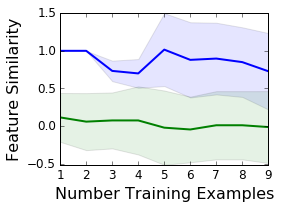

In [38]:
graph(outerdiffx,outerdiffy1,outerdiffy2,outerdiffy1std,outerdiffy2std,title="diff-unregularized", legend="lower right")

fname =  ('figures/regression-diff_unregularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [41]:
outerregW = np.zeros((N,N))
outerregW = outer_reg_train(outerregW, trainpast2[0], trainpres1[0], cos_sim)

outerregx = np.arange(1, trainpres1.shape[0], 1)
outerregy1 = np.zeros(outerregx.shape[0])
outerregy2 = np.zeros(outerregx.shape[0])
outerregy1std = np.zeros(outerregx.shape[0])
outerregy2std = np.zeros(outerregx.shape[0])

outerregy1irregular = np.zeros(outerregx.shape[0])
outerregy2irregular = np.zeros(outerregx.shape[0])

sim2indices = [j for j in range(testpres1.shape[0]) if test_all_indices[j] >= len(test_reg)]

for i in range(outerregx.shape[0]):
    k = outerregx[i]
    #train_pred = W.T.dot(trainpres1[:k].T).T
    #test_pred = W.T.dot(testpres1.T).T
    
    train_pred = np.dot(outerregW, trainpres1[:k, :].T).T
    test_pred = np.dot(outerregW, testpres1.T).T
    
    sim1 = cos_sim(train_pred, trainpast2[:k])
    sim2 = cos_sim(test_pred, testpast2)
    
    sim1indices = [j for j in range(sim1.shape[0]) if train_all_indices[j] >= len(train_reg)]

    irregularsim1 = sim1[sim1indices]
    irregularsim2 = sim2[sim2indices]
    
    outerregy1[i] = sim1.mean()/N**2
    outerregy1std[i] = np.nanstd(sim1, axis=0)/N**2
    outerregy2[i] = sim2.mean()/N**2
    outerregy2std[i] = np.nanstd(sim2, axis=0)/N**2
    
    outerregy1irregular[i] = irregularsim1.mean()/N**2
    outerregy2irregular[i] = irregularsim2.mean()/N**2
    
    outerregW = outer_reg_train(outerregW, trainpast2[k], trainpres1[k], cos_sim)

/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: Mean of empty slice.


figures/regression-regularized_outer_trigam_dict-N=10-W=10-170831


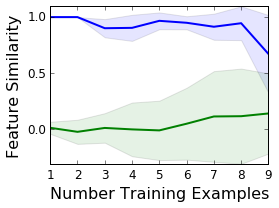

In [42]:
graph(outerregx,outerregy1,outerregy2,outerregy1std,outerregy2std,title="regularized", legend="upper left")

fname =  ('figures/regression-regularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname
plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [45]:
def outer_reg_train_diff(W, past2, present1, present2, sim):
    #W.T.dot(trainpres1[:k].T).T + trainpres2[:k]*N
    pred = np.dot(W, present1) + present2*N
    W += ((N*N-sim(pred, past2*N))/float(N*N)) * np.outer(present1, past2-present2)
    return W

In [47]:
outerregdiffW = np.zeros((N,N))
outerregdiffW = outer_reg_train_diff(outerregdiffW, trainpast2[0], trainpres1[0], trainpres2[0], cos_sim)

outerregdiffx = np.arange(1, trainpres1.shape[0], 1)
outerregdiffy1 = np.zeros(outerregdiffx.shape[0])
outerregdiffy2 = np.zeros(outerregdiffx.shape[0])

outerregdiffy1std = np.zeros(outerregdiffx.shape[0])
outerregdiffy2std = np.zeros(outerregdiffx.shape[0])

outerregdiffy1irregular = np.zeros(outerregdiffx.shape[0])
outerregdiffy2irregular = np.zeros(outerregdiffx.shape[0])

sim2indices = [j for j in range(testpres1.shape[0]) if test_all_indices[j] >= len(test_reg)]

for i in range(outerregdiffx.shape[0]):#trainpres1.shape[0]):
    k = outerregdiffx[i]

    train_pred = outerregdiffW.T.dot(trainpres1[:k].T).T + trainpres2[:k]*N
    test_pred = outerregdiffW.T.dot(testpres1.T).T + (testpres2*N)
    
    #print (train_pred.shape, test_pred.shape)
#     y1[i] = sim(train_pred/float(N), trainpast2[:k]).mean()
#     y2[i] = sim(test_pred/float(N), testpast2).mean()
    
    sim1 = cos_sim(train_pred, trainpast2[:k])
    sim2 = cos_sim(test_pred, testpast2)
    
    sim1indices = [j for j in range(sim1.shape[0]) if train_all_indices[j] >= len(train_reg)]

    irregularsim1 = sim1[sim1indices]
    irregularsim2 = sim2[sim2indices]
    
    outerregdiffy1[i] = sim1.mean()/N**2
    outerregdiffy1std[i] = np.nanstd(sim1, axis=0)/N**2
    outerregdiffy2[i] = sim2.mean()/N**2
    outerregdiffy2std[i] = np.nanstd(sim2, axis=0)/N**2
    
    outerregdiffy1irregular[i] = irregularsim1.mean()/N**2
    outerregdiffy2irregular[i] = irregularsim2.mean()/N**2
      
    outerregdiffW = outer_reg_train_diff(outerregdiffW, trainpast2[k], trainpres1[k], trainpres2[k], cos_sim)

/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: Mean of empty slice.


figures/regression-diff_regularized_outer_trigam_dict-N=10-W=10-170831


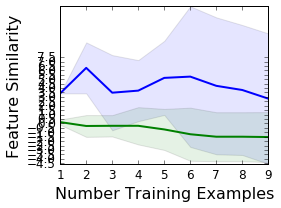

In [48]:
graph(outerregdiffx,outerregdiffy1,outerregdiffy2,outerregdiffy1std,outerregdiffy2std,title='diff-regularized', legend='upper left')

fname =  ('figures/regression-diff_regularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [49]:
# end of outer_product_algorithm A, B, (bind, diff unreg) C, D (bind, diff reg)

In [50]:
regpsi = np.zeros(N)
regpsi = reg_train(regpsi, trainpast2[0], trainpres1[0], cos_sim)

regx = np.arange(1, trainpres1.shape[0]+1, 1)
regy1 = np.zeros(trainpres1.shape[0])
regy2 = np.zeros(trainpres1.shape[0])
regy1std = np.zeros(trainpres1.shape[0])
regy2std = np.zeros(trainpres1.shape[0])

regy1irregular = np.zeros(trainpres1.shape[0])
regy2irregular = np.zeros(trainpres1.shape[0])

sim2indices = [i for i in range(testpres1.shape[0]) if test_all_indices[i] >= len(test_reg)]

for k in range(1,len(trainpres1)):#trainpres1.shape[0]):
    train_pred = np.multiply(regpsi, trainpres1[:k])
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(regpsi, testpres1)
    #test_pred = np.where(test_pred>0, 1, -1)

    sim1 = cos_sim(train_pred, trainpast2[:k])
    sim2 = cos_sim(test_pred, testpast2)
    
    sim1indices = [i for i in range(sim1.shape[0]) if train_all_indices[i] >= len(train_reg)]

    irregularsim1 = sim1[sim1indices]
    irregularsim2 = sim2[sim2indices]
    
    regy1[k] = sim1.mean()/N
    regy1std[k] = np.nanstd(sim1, axis=0)/N #/ (arange(len(train_mean))+1) ** 0.5
    regy2[k] = sim2.mean()/N
    regy2std[k] = sim2.std(axis=0)/N #/ testpast2.shape[0]**0.5
    
    regy1irregular[k] = irregularsim1.mean()/N
    regy2irregular[k] = irregularsim2.mean()/N
    
    
    regpsi = reg_train(regpsi, trainpast2[k], trainpres1[k], cos_sim)


/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: Mean of empty slice.


figures/LowRankSolver-regularized_trigam_dict-N=10-W=10-170831


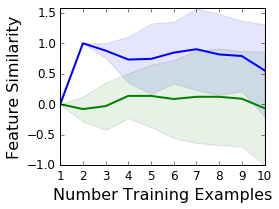

In [51]:
graph(regx,regy1,regy2,regy1std,regy2std,title="regularized",legend="lower right")

fname =  ('figures/LowRankSolver-regularized_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [52]:
regdiffpsi = np.zeros(N)
regdiffpsi = reg_train_diff(regdiffpsi, trainpast2[0], trainpres1[0], trainpres2[0], cos_sim)

regdiffx = np.arange(1, trainpres1.shape[0]+1, 1)
regdiffy1 = np.zeros(trainpres1.shape[0])
regdiffy2 = np.zeros(trainpres1.shape[0])
regdiffy1std = np.zeros(trainpres1.shape[0])
regdiffy2std = np.zeros(trainpres1.shape[0])

regdiffy1irregular = np.zeros(trainpres1.shape[0])
regdiffy2irregular = np.zeros(trainpres1.shape[0])

sim2indices = [i for i in range(testpres1.shape[0]) if test_all_indices[i] >= len(test_reg)]

for k in range(1,len(trainpres1)):#trainpres1.shape[0]):
    train_pred = np.multiply(regdiffpsi, trainpres1[:k]) + trainpres2[:k]
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(regdiffpsi, testpres1) + testpres2
    #test_pred = np.where(test_pred>0, 1, -1)

    sim1 = cos_sim(train_pred, trainpast2[:k])
    sim2 = cos_sim(test_pred, testpast2)
    
    sim1indices = [i for i in range(sim1.shape[0]) if train_all_indices[i] >= len(train_reg)]

    irregularsim1 = sim1[sim1indices]
    irregularsim2 = sim2[sim2indices]
    
    regdiffy1[k] = sim1.mean()/N
    regdiffy1std[k] = np.nanstd(sim1, axis=0)/N #/ (arange(len(train_mean))+1) ** 0.5
    regdiffy2[k] = sim2.mean()/N
    regdiffy2std[k] = sim2.std(axis=0)/N #/ testpast2.shape[0]**0.5
    
    regdiffy1irregular[k] = irregularsim1.mean()/N
    regdiffy2irregular[k] = irregularsim2.mean()/N
    
    regdiffpsi = reg_train_diff(regdiffpsi, trainpast2[k], trainpres1[k], trainpres2[k], cos_sim)


/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: Mean of empty slice.


figures/LowRankSolver-diff_regularized_trigam_dict-N=10-W=10-170831


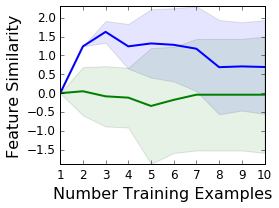

In [53]:
graph(regdiffx,regdiffy1,regdiffy2,regdiffy1std,regdiffy2std,"diff-regularized")


fname =  ('figures/LowRankSolver-diff_regularized_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [54]:
# end of vector_algo A, B, (bind, diff unreg) C, D (bind, diff reg)

In [71]:
closedx = np.arange(1, trainpres1.shape[0], 10)
closedy1 = np.zeros(closedx.shape[0])
closedy2 = np.zeros(closedx.shape[0])
closedy1std = np.zeros(closedx.shape[0])
closedy2std = np.zeros(closedx.shape[0])

closedy1irregular = np.zeros(closedx.shape[0])
closedy2irregular = np.zeros(closedx.shape[0])

sim2indices = [j for j in range(testpres1.shape[0]) if test_all_indices[j] >= len(test_reg)]

for i in range(closedx.shape[0]):#trainpres1.shape[0]):
    k = closedx[i]
    closedW = closed_train(trainpast2[:k], trainpres1[:k])
    train_pred = trainpres1[:k].dot(closedW)
    test_pred = testpres1.dot(closedW)

    sim1 = cos_sim(train_pred, trainpast2[:k])
    sim2 = cos_sim(test_pred, testpast2)
    
    sim1indices = [j for j in range(sim1.shape[0]) if train_all_indices[j] >= len(train_reg)]

    irregularsim1 = sim1[sim1indices]
    irregularsim2 = sim2[sim2indices]
    
    closedy1[i] = sim1.mean()/N
    closedy1std[i] = np.nanstd(sim1, axis=0)/N
    closedy2[i] = sim2.mean()/N
    closedy2std[i] = np.nanstd(sim2, axis=0)/N
    
    closedy1irregular[i] = irregularsim1.mean()/N
    closedy2irregular[i] = irregularsim2.mean()/N


/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: Mean of empty slice.


figures/regression-unregularized_closedform-trigram-N=100-W=500-170831


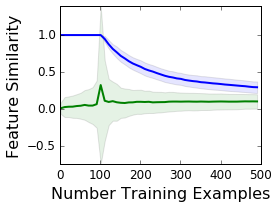

In [72]:
graph(closedx,closedy1,closedy2,closedy1std,closedy2std,title="unregularized", legend="lower right")

fname =  ('figures/regression-unregularized_closedform-trigram-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [65]:
capx = np.arange(1, trainpres1.shape[0], 10)
capy1 = np.zeros(capx.shape[0])
capy2 = np.zeros(capx.shape[0])
capy1std = np.zeros(capx.shape[0])
capy2std = np.zeros(capx.shape[0])

capy1irregular = np.zeros(capx.shape[0])
capy2irregular = np.zeros(capx.shape[0])

sim2indices = [j for j in range(testpres1.shape[0]) if test_all_indices[j] >= len(test_reg)]

for i in range(capx.shape[0]):#trainpres1.shape[0]):
    k = capx[i]
    capW = cap_closed_train(trainpast2[:k], trainpres1[:k])
    train_pred = trainpres1[:k].dot(capW)
    test_pred = testpres1.dot(capW)

    sim1 = cos_sim(train_pred, trainpast2[:k])
    sim2 = cos_sim(test_pred, testpast2)
    
    sim1indices = [j for j in range(sim1.shape[0]) if train_all_indices[j] >= len(train_reg)]

    irregularsim1 = sim1[sim1indices]
    irregularsim2 = sim2[sim2indices]
    
    capy1[i] = sim1.mean()/N
    capy1std[i] = np.nanstd(sim1, axis=0)/N
    capy2[i] = sim2.mean()/N
    capy2std[i] = np.nanstd(sim2, axis=0)/N
    
    capy1irregular[i] = irregularsim1.mean()/N
    capy2irregular[i] = irregularsim2.mean()/N
    

/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: Mean of empty slice.


figures/regression-unregularized_cap_closedform-trigram-N=100-W=100-170831


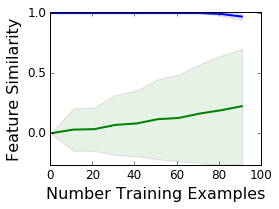

In [66]:
graph(capx,capy1,capy2,capy1std,capy2std,title="unregularized", legend="lower right")

fname =  ('figures/regression-unregularized_cap_closedform-trigram-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)
